In [1]:
import tensorflow as tf 
import keras

from sklearn.feature_extraction.text import TfidfVectorizer
import glob
import os 
import pandas as pd
import datetime
from scipy.stats import iqr
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split

from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer as SimpleImputer
# from sklearn.impute import SimpleImputer



import matplotlib.pyplot as plt
%matplotlib inline

import math

spm = None
english_words = None
excepted_stock_names = []
limit = -1

Using TensorFlow backend.


In [20]:
import keras
from keras.layers import Dense, Dropout, RepeatVector, BatchNormalization, Convolution1D, Flatten, Lambda, Permute, MaxPooling1D, AlphaDropout
from keras.models import Sequential
from keras.utils import to_categorical
import keras.backend as K
from sklearn.model_selection import train_test_split
from keras.models import load_model
from tqdm import *

In [21]:
class DateRange():
    def __init__(self, start_int, end_int):
        self.start_int = start_int
        self.end_int = end_int
        self.range = (range(start_int, end_int))

    def transform(self, date):
        output = {}
        dates = []
        for delta in self.range:
            date_delta = datetime.timedelta(days=delta)
            date_string = datetime.datetime.strptime(date, '%Y-%m-%d').date()
            dates.append(str(date_string + date_delta))
        return dates

In [22]:
class PriceData:
    def __init__(self, stock_name):
        self.stock_name = stock_name
        try:
            self.price_data = pd.read_csv('prices/' + stock_name + '.csv')
        except:
            self.price_data = pd.DataFrame.from_dict({})

    def on_date(self, date, market_time = 'open'): 
        try:
            return float(self.price_data.loc[self.price_data['date'] == date][market_time])
        except: 
            return None

In [23]:
class X_y_mapping():
    def __init__(self, start_int, end_int):
        self.filing_int = start_int * -1
        self.start_int = start_int
        self.end_int = end_int
        self.range = (range(start_int, end_int))
        
    def __stock_name_from_filename(self, filename):
        return filename.split('/')[-1]
        
    def transform(self):
        stock_names = [self.__stock_name_from_filename(filename) for filename in glob.glob('filing_texts/*')]
        price_ranges = self.__get_price_ranges(stock_names)
        X_y = {}
        for stock_name in price_ranges.keys():
            cp_ratio = self.__comparison_price_ratio(price_ranges, stock_name)
            if cp_ratio and not math.isnan(cp_ratio):
                X_y[stock_name] = cp_ratio
        return X_y
    
    
    def __get_price_ranges(self, stock_names):
        h = {}
        for i, stock_name in enumerate(stock_names):
            try:
                date = stock_name.split('_')[1]
            except:
                continue # Ignore stocks which don't have a date
            dates = []
            for delta in self.range:
                date_delta = datetime.timedelta(days=delta)
                date_string = datetime.datetime.strptime(date, '%Y-%m-%d').date()
                dates.append(str(date_string + date_delta))
            h[stock_name] = dates
        return h
    
    def __comparison_price_ratio(self,h, stock_name_with_date):
        earliest_price_after_filing = None
        hist_p = []
        stock_name = stock_name_with_date.split('_')[0]
        for i, date in enumerate(h[stock_name_with_date]):
            price = PriceData(stock_name).on_date(date, 'open')
            if price and not math.isnan(price):
                if i > self.filing_int:
                    earliest_price_after_filing = earliest_price_after_filing or price
                else:
                    hist_p.append(price)
        # Closing price on day of filing
        price_close_filing = PriceData(stock_name).on_date(h[stock_name_with_date][self.filing_int], 'close')
        # Use either the next open day of trading or the close price on day of filing
        comparison_price = earliest_price_after_filing or price_close_filing
        # Remove nans from historical prices before taking the mean
        this_mean = np.mean(hist_p)
        if comparison_price and this_mean:
            return ((comparison_price-this_mean)/this_mean)
        else:
            return None

In [24]:
spm = X_y_mapping(-3,4).transform()
spm

/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'ADOM_2018-06-05': -0.052980132450331174,
 'INVE_2018-06-05': 0.012687427912341342,
 'ABIO_2018-06-05': -0.018898056960340782,
 'LIFE_2018-06-04': -0.05027932960893859,
 'AVA_2018-05-31': 0.0035369467546122768,
 'HUM_2018-05-31': -0.0046658946938221545,
 'SUNW_2018-06-05': 0.01287553648068661,
 'HPHW_2018-06-04': -0.5694444444444444,
 'PRPO_2018-06-04': 0.0029876227059324727,
 'PDLI_2018-06-05': -0.01119402985074636,
 'AMED_2018-06-04': 0.009940874537066938,
 'CUTR_2018-06-04': 0.07014492753623185,
 'GNK_2018-06-05': 0.007399577167018869,
 'MC_2018-06-08': 0.02916918125125729,
 'NAKD_2018-06-01': 0.049008359285363116,
 'IBP_2018-05-31': 0.021449904968775628,
 'EPR_2018-06-01': -0.0007339150289487825,
 'EXPO_2018-05-31': 0.01024065540194587,
 'FULT_2018-05-31': -0.030418250950570432,
 'SNMX_2018-05-31': 0.0024390243902441214,
 'COLD_2018-06-06': 0.006021306160259168,
 'LAND_2018-05-31': -0.007238883143743428,
 'XLRN_2018-06-05': 0.007202216066481939,
 'MASI_2018-06-04': -0.004877563209

In [25]:
len(spm)

475

In [26]:
class FilenamesToStockNamesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
        
    def transform(self, X):
        output = []
        for filename in X:
            stock_name = self.__stock_name_from_filename(filename)
            output.append(stock_name)
        return output
    def __stock_name_from_filename(self, filename):
        return filename.split('/')[-1].split('_')[0]

In [27]:
## Used in y pipeline
class SpmToFileNamesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
    def transform(self, X):
        output = []
        for key in X.keys():
            output.append(f'filing_texts/{key}')
        return output
    
class SpmToStockNamesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
        
    def transform(self, X):
        return X.keys()
    
class StockNamesToFileNamesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
        
    def transform(self, X):
        return [f'filing_texts/{stock_name}' for stock_name in X]
    
class StatisticalMeasuresTransformer(BaseEstimator, TransformerMixin):
    # Returns the interquartile-range and median.
    def __init__(self):
        return None
        
    def fit(self, X, y=None):
        # ldcom = last_day_change_over_median
        
        output = []
        self.iqr_var = []
        self.median = []
        for prices in X:
            this_iqr = iqr(prices[0:-3])
            this_median = np.median(prices[0:-3])
            self.iqr_var.append(this_iqr)
            self.median.append(this_median)
        return self
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
        
    def transform(self, X):
        X_output = []
        for i, prices in enumerate(X):
            stats   = []
            iqr_var = self.iqr_var[i] or iqr(prices)
            median  = self.median[i]  or np.median(prices)
            
            stats.append(iqr_var)
            stats.append(median)
            
            X_output.append(stats)
        return np.array(X_output)
class SparseToArray(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
        
    def fit(self, X, y=None):
        return self
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
        
    def transform(self, X):
        return np.array(X.toarray()) #[ar.toarray() for ar in X]
    
class ReadFiles(BaseEstimator, TransformerMixin): 
    def __init__(self):
        return None
        
    def fit(self, X, y=None):
        return self
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
        
    def transform(self, X):
        return (open(filename, 'r').read() for filename in tqdm(X))
            

In [28]:
class SpmToContinuousLabelsTransformer(BaseEstimator, TransformerMixin): 
    def __init__(self):
        return None
        
    def fit(self, X, y=None):
        return self
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
        
    def transform(self, X):
        return np.array(list(X.values()))

In [29]:
# Used to build other pipelines
from sklearn.preprocessing import Imputer

labels_pipeline = Pipeline([
    ('dates_to_prices_transformer', SpmToContinuousLabelsTransformer())
])

text_word_counts = Pipeline([
    ('spm_to_file_names', SpmToFileNamesTransformer()),
    ('read_files', ReadFiles()),
    ('vect', TfidfVectorizer(
                token_pattern=r"[a-zA-Z]+", 
                min_df = 0.02,
                max_df = 0.95,
                stop_words = 'english',
                ngram_range=(1, 2))),
    ('sparse_to_array', SparseToArray()),
    ('std_scaler', StandardScaler(with_mean=False)),
])


In [30]:
X = text_word_counts.fit_transform(spm)
y = labels_pipeline.fit_transform(spm)
print(X.shape)
print(y.shape)

100%|██████████| 475/475 [01:36<00:00,  4.92it/s]


(475, 482710)
(475,)


In [31]:
X_train, X_test, y_train_continuous, y_test_continuous = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
def bool_arr(arr, limit=0.5):
    y_bool = []
    for num in arr:
        if num >= limit:
            y_bool.append(1)
        else:
            y_bool.append(0)
    return np.array(y_bool)
y_train = bool_arr(y_train_continuous, 0.1)
y_test = bool_arr(y_test_continuous, 0.1)

In [33]:
from sklearn.feature_selection import SelectFpr
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
import tensorflow as tf


svc_train_pipeline = Pipeline([
    ('reduce_false_pos', SelectFpr(alpha=0.1)),
    ('svc', GridSearchCV(estimator=SVC(gamma='auto'), param_grid=dict(C=np.logspace(0,2.5)), n_jobs=1))
])
svc_train_pipeline.fit(X_train, y_train)
svc_train_pipeline.score(X_test, y_test)

KeyboardInterrupt: 

In [35]:
svc_train_pipeline = Pipeline([
    ('reduce_false_pos', SelectFpr(alpha=0.1)),
    ('svc', SVC(C=100, probability=True))
])
# clf = RandomForestRegressor(n_estimators=200, max_depth=3, verbose=1, n_jobs=2)
svc_train_pipeline.fit(X_train, y_train)
svc_train_pipeline.score(X_test, y_test)



0.968421052631579

(-0.1, 0.1)

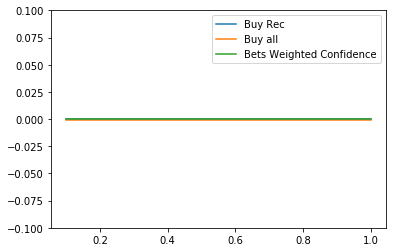

In [38]:
def score(est, X, y, cutoff):
    y_pred = est.predict(X)
    # Invest if over cutoff% confident 
    y_pred_bool = bool_arr(y_pred, cutoff)
    # Score correct if you make postive returns
    y_true_bool = bool_arr(y, 0)
    
    total = np.dot(y_pred_bool.reshape(X.shape[0],), y)
    confidence_weighted = np.dot(y_pred.reshape(X.shape[0],), y)
    buy_all = np.dot(np.ones(X.shape[0]), y)
    
    av = total/len(X)
    buy_all_av = buy_all/len(X)
    confidence_weighted_av = confidence_weighted/len(X)
    return [av, buy_all_av, confidence_weighted_av]


ys_attained = []
ys_potential = []
ys_confidence_weighted = []
xs = []
for i in np.linspace(0.1, 1, num=10):
    sc = score(svc_train_pipeline, X_test, y_test_continuous,i)
    ys_attained.append(sc[0])
    ys_potential.append(sc[1])
    ys_confidence_weighted.append(sc[2])
    xs.append(i)
    
buy_rec = plt.plot(xs, ys_attained, label='Buy Rec')
buy_all = plt.plot(xs, ys_potential, label='Buy all')
buy_wc = plt.plot(xs, ys_confidence_weighted, label='Bets Weighted Confidence')

ax = plt.gca()

handles, labels = ax.get_legend_handles_labels()
ax.legend()

plt.ylim(-0.1, 0.1)

# set the ylim to ymin, ymax

In [39]:
from keras import regularizers
from sklearn.metrics import confusion_matrix

In [77]:
class DeepEstimator():
    def __init__(self):
        return None
    def fit(self, X, y, X_val, y_val):
        class_weight = {0: 0.4,
                1: 0.6}
        self.model = self.__define_model(X)
#         sched = [[0.0001, 2], [0.001, 20], [0.01, 2], [0.1, 2], [0.5, 1], [0.1, 5], [0.01, 20], [0.001, 40], [0.0001, 80], [0.00005, 120]]
        sched = [[0.0001, 10]]
        for lr, epochs in sched:
            self.model.optimizer.lr = lr
            self.model.fit(np.array(X), np.array(y), epochs=epochs, verbose=True, class_weight=class_weight, batch_size=2, validation_data=(X_val, y_val))
        return self
    def predict(self, X, y=None):
        return self.model.predict(X)
    def __define_model(self, X):
        shape = X.shape[1]
        model = Sequential([
            BatchNormalization(input_shape=(shape,)),
            Dense(32, activation='relu', kernel_regularizer=regularizers.l1(0.5)),
            Dropout(0.5),
            BatchNormalization(),
            Dense(32, activation='relu', kernel_regularizer=regularizers.l1(0.5)),
            Dropout(0.5),
            BatchNormalization(),
            Dense(1, activation='sigmoid')   
        ])

        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        return model
    
X_train, X_test, y_train_continuous, y_test_continuous = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = bool_arr(y_train_continuous, 0.01)
y_test = bool_arr(y_test_continuous, 0.01)

select_fpr = SelectFpr(alpha=0.05)

X_train = select_fpr.fit_transform(X_train, y_train)
X_test = select_fpr.transform(X_test)

deep_estimator = DeepEstimator()
deep_estimator.fit(X_train, y_train, X_test, y_test)

Train on 380 samples, validate on 95 samples
Epoch 1/10


ResourceExhaustedError: OOM when allocating tensor of shape [19296] and type float
	 [[Node: batch_normalization_53/Const_1 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [19296] values: 0 0 0...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op 'batch_normalization_53/Const_1', defined at:
  File "/home/piper/anaconda2/envs/sls_sec/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/piper/anaconda2/envs/sls_sec/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/piper/anaconda2/envs/sls_sec/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/piper/anaconda2/envs/sls_sec/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/piper/anaconda2/envs/sls_sec/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2909, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-77-06639b8d71a6>", line 44, in <module>
    deep_estimator.fit(X_train, y_train, X_test, y_test)
  File "<ipython-input-77-06639b8d71a6>", line 7, in fit
    self.model = self.__define_model(X)
  File "<ipython-input-77-06639b8d71a6>", line 26, in __define_model
    Dense(1, activation='sigmoid')
  File "/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/keras/models.py", line 441, in __init__
    self.add(layer)
  File "/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/keras/models.py", line 497, in add
    layer(x)
  File "/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/keras/engine/topology.py", line 592, in __call__
    self.build(input_shapes[0])
  File "/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/keras/layers/normalization.py", line 115, in build
    constraint=self.beta_constraint)
  File "/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/keras/engine/topology.py", line 413, in add_weight
    weight = K.variable(initializer(shape),
  File "/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/keras/initializers.py", line 38, in __call__
    return K.constant(0, shape=shape, dtype=dtype)
  File "/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 424, in constant
    return tf.constant(value, dtype=dtype, shape=shape, name=name)
  File "/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/tensorflow/python/framework/constant_op.py", line 220, in constant
    name=name).outputs[0]
  File "/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor of shape [19296] and type float
	 [[Node: batch_normalization_53/Const_1 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [19296] values: 0 0 0...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]


In [ ]:
# deep_estimator.model.optimizer.lr = 0
# deep_estimator.model.fit(np.array(X_train), np.array(y_train), epochs=10, verbose=True, batch_size=4096, validation_data=(X_test, y_test))

/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


(-0.005, 0.005)

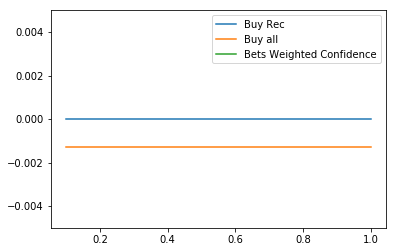

In [44]:
def score(est, X, y, cutoff):
    y_pred = est.predict(X)
    y_pred_proba = est.model.predict_proba(X)
    # Invest if over cutoff% confident 
    y_pred_bool = bool_arr(y_pred, cutoff)
    # Score correct if you make postive returns
    y_true_bool = bool_arr(y, 0)
    
    total = np.dot(y_pred_bool.reshape(X.shape[0],), y)
    confidence_weighted = np.dot(y_pred_proba.reshape(X.shape[0],), y)
    buy_all = np.dot(np.ones(X.shape[0]), y)
    
    av = total/len(X)
    buy_all_av = buy_all/len(X)
    confidence_weighted_av = confidence_weighted/len(X)
    return [av, buy_all_av, confidence_weighted_av]


ys_attained = []
ys_potential = []
ys_confidence_weighted = []
xs = []
for i in np.linspace(0.1, 1, num=10):
    sc = score(deep_estimator, X_test, y_test_continuous,i)
    ys_attained.append(sc[0])
    ys_potential.append(sc[1])
    ys_confidence_weighted.append(sc[2])
    xs.append(i)
    
buy_rec = plt.plot(xs, ys_attained, label='Buy Rec')
buy_all = plt.plot(xs, ys_potential, label='Buy all')
buy_wc = plt.plot(xs, ys_confidence_weighted, label='Bets Weighted Confidence')

ax = plt.gca()

handles, labels = ax.get_legend_handles_labels()
ax.legend()

plt.ylim(-0.005, 0.005)

# set the ylim to ymin, ymax

In [42]:
ys_confidence_weighted = []
ys_potential = []
xs = []

for i in tqdm(np.linspace(0,0.2, num=5)):
    X_train, X_test, y_train_continuous, y_test_continuous = train_test_split(X, y, test_size=0.2, random_state=42)
    y_train = bool_arr(y_train_continuous, i)
    y_test = bool_arr(y_test_continuous, i)

    select_fpr = SelectFpr(alpha=0.2)

    X_train = select_fpr.fit_transform(X_train, y_train)
    X_test = select_fpr.transform(X_test)

    deep_estimator = DeepEstimator()
    deep_estimator.fit(X_train, y_train, X_test, y_test)
    
    round_score = score(deep_estimator, X_test, y_test_continuous,0)
    
    buy_all_score = round_score[1]
    bwc_score = round_score[2]
    
    xs.append(i)
    ys_potential.append(buy_all_score)
    ys_confidence_weighted.append(bwc_score)



100%|██████████| 10/10 [01:17<00:00,  7.74s/it]
/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/home/piper/anaconda2/envs/sls_sec/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
100%|██████████| 5/5 [07:49<00:00, 93.88s/it] 


# Plot earnings on buying weighted by confidence vs buying all stocks as the prediction threshold increases in training

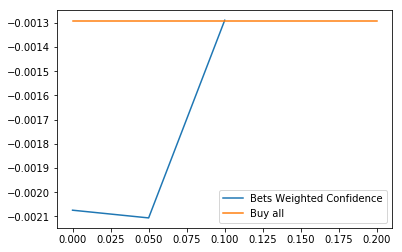

In [43]:
plt.plot(xs, ys_confidence_weighted, label='Bets Weighted Confidence')
buy_all = plt.plot(xs, ys_potential, label='Buy all')

ax = plt.gca()

handles, labels = ax.get_legend_handles_labels()
ax.legend()

In [107]:
y_test_continuous

array([ 0.01970443, -0.0092299 , -0.0786802 ,  0.069869  , -0.04415385,
        0.0600907 ,  0.28119181,  0.03900156,  0.01505692, -0.00578261,
        0.07009215,  0.04555315, -0.07559101,  0.03318888, -0.02040816,
       -0.17647059, -0.11111111,  0.00705219, -0.00495037, -0.0699187 ,
       -0.00068313,  0.03950362, -0.00417604, -0.02918587, -0.07531351,
        0.04026403,  0.02359282,  0.00710136,  0.00243902, -0.01942646,
       -0.03681885, -0.05263158, -0.00869565,  0.01960784, -0.01098007,
        0.0031348 ,  0.00230491,  0.04697987,  0.00878477,  0.0173488 ,
       -0.09119497,  0.04697987, -0.09926285,  0.0052356 ,  0.01152026,
       -0.01156677,  0.05620316,  0.06036816,  0.0428215 ,  0.05054509,
       -0.02538997,  0.06813996,  0.01102858,  0.19508495,  0.01763763,
        0.00318471, -0.05793178,  0.01682823, -0.08114286,  0.01098129,
        0.02366007, -0.0070713 ,  0.09880952, -0.02629286, -0.0010601 ,
       -0.00967701,  0.00770077,  0.01294159, -0.01765875,  0.04